In [1]:
import sys, os, datetime
sys.path.append("../../")

from utils.contract_utils import init_contract
from utils.network_utils import configure_network_and_connect

import brownie

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
configure_network_and_connect(
    node_provider_https=f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}",
    network_name='mainnet'
)

In [4]:
ankreth = "0xA96A65c051bF88B4095Ee1f2451C2A9d43F53Ae2"

In [5]:
pool_contract_addr = ankreth

pool_contract = init_contract(contract_addr=pool_contract_addr)
pool_info = pool_contract.info()

initial_A = pool_contract.initial_A()
initial_A_time = pool_contract.initial_A_time()
A = pool_contract.A()
A_precise = pool_contract.A_precise()
A_precision = int(A_precise/A)

print(f"pool param details:")
print(f"initial_A: {initial_A}")
print(f"initial_A_time: {initial_A_time}")
print(f"A: {A}")
print(f"A_precise: {A_precise}")
print(f"A_precision: {A_precision}")

  @title ETH/ankrETH StableSwap
  @author Curve.Fi

pool param details:
initial_A: 1000
initial_A_time: 0
A: 10
A_precise: 1000
A_precision: 100


In [6]:
coin_addr = pool_contract.coins(0)
if coin_addr == "0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE":
    coin_0 = "ETH"
else:
    coin_0 = init_contract(coin_addr).name()

coin_addr = pool_contract.coins(1)
if coin_addr == "0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE":
    coin_1 = "ETH"
else:
    coin_1 = init_contract(coin_addr).name()

print(coin_0, ',', coin_1)

ETH , Ankr ETH2 Reward Bearing Certificate


before incentivisation:

In [7]:
block_number = 13222324
block_details = brownie.web3.eth.get_block(block_number)
block_time = datetime.datetime.fromtimestamp(block_details['timestamp'])
block_time

datetime.datetime(2021, 9, 14, 12, 24, 28)

In [8]:
try:
    pool_balances = pool_contract.get_balances(block_identifier=block_number)
except:  # old vyper contracts did not have get_balances method
    pool_balances_0 = pool_contract.balances(0, block_identifier=block_number)
    pool_balances_1 = pool_contract.balances(1, block_identifier=block_number)
    pool_balances = (pool_balances_0, pool_balances_1)

total_coins = (pool_balances[1]+pool_balances[0])

coin_perc_string = f"Pool ratios at {block_number} ({block_time}): {coin_0}: {round(pool_balances[0]/total_coins * 100, 2)}%, {coin_1}: {round(pool_balances[1]/total_coins * 100, 2)}%"

coin_perc_string

'Pool ratios at 13222324 (2021-09-14 12:24:28): ETH: 28.54%, Ankr ETH2 Reward Bearing Certificate: 71.46%'

after incentivisation:

In [9]:
block_number = 13280770
block_details = brownie.web3.eth.get_block(block_number)
block_time = datetime.datetime.fromtimestamp(block_details['timestamp'])
block_time

datetime.datetime(2021, 9, 23, 13, 27, 56)

In [10]:
try:
    pool_balances = pool_contract.get_balances(block_identifier=block_number)
except:  # old vyper contracts did not have get_balances method
    pool_balances_0 = pool_contract.balances(0, block_identifier=block_number)
    pool_balances_1 = pool_contract.balances(1, block_identifier=block_number)
    pool_balances = (pool_balances_0, pool_balances_1)

total_coins = (pool_balances[1]+pool_balances[0])

coin_perc_string = f"Pool ratios at {block_number} ({block_time}): {coin_0}: {round(pool_balances[0]/total_coins * 100, 2)}%, {coin_1}: {round(pool_balances[1]/total_coins * 100, 2)}%"

coin_perc_string

'Pool ratios at 13280770 (2021-09-23 13:27:56): ETH: 38.83%, Ankr ETH2 Reward Bearing Certificate: 61.17%'

combine this into a function:

In [11]:
def get_peg_from_block(
    block_number_start: int, 
    pool_contract: brownie.Contract, 
    block_steps: int = 10000
) -> pd.DataFrame:

    current_block = brownie.web3.eth.block_number
    blocks_to_calculate = list(range(block_number_start, current_block, block_steps))
    blocks_to_calculate.append(current_block)

    data = {'timestamp': [], 'block_number': [], 'coin_0_perc': [], 'coin_1_perc': [], 'peg_ratio': []}

    for block_number in blocks_to_calculate:

        block_details = brownie.web3.eth.get_block(block_number)
        block_time = datetime.datetime.fromtimestamp(block_details['timestamp'])

        try:
            pool_balances = pool_contract.get_balances(block_identifier=block_number)
        except:  # old vyper contracts did not have get_balances method
            pool_balances_0 = pool_contract.balances(0, block_identifier=block_number)
            pool_balances_1 = pool_contract.balances(1, block_identifier=block_number)
            pool_balances = (pool_balances_0, pool_balances_1)

        total_coins = (pool_balances[1]+pool_balances[0])

        coin_0_perc = round(pool_balances[0]/total_coins * 100, 2)
        coin_1_perc = round(pool_balances[1]/total_coins * 100, 2)

        peg_ratio = round(min(coin_0_perc, coin_1_perc) / max(coin_0_perc, coin_1_perc), 2)

        data['timestamp'].append(block_time)
        data['block_number'].append(block_number)
        data['coin_0_perc'].append(coin_0_perc)
        data['coin_1_perc'].append(coin_1_perc)
        data['peg_ratio'].append(peg_ratio)

    df_data = pd.DataFrame(data)

    return df_data.set_index('timestamp')


In [12]:
df_pool_peg = get_peg_from_block(block_number_start=13022595, pool_contract=pool_contract, block_steps=5000)

bar plot

In [27]:
plot_start_date = pd.Timestamp("2021-09-10")
df_plot = df_pool_peg[df_pool_peg.index > plot_start_date]
df_plot.reset_index(inplace=True)

In [28]:
df_plot

,timestamp,block_number,coin_0_perc,coin_1_perc,peg_ratio
0,2021-09-10 16:28:17,13197595,27.58,72.42,0.38
1,2021-09-11 11:01:02,13202595,27.51,72.49,0.38
2,2021-09-12 05:43:18,13207595,27.31,72.69,0.38
3,2021-09-13 00:03:57,13212595,27.07,72.93,0.37
4,2021-09-13 18:52:41,13217595,27.02,72.98,0.37
5,2021-09-14 13:20:59,13222595,28.54,71.46,0.40
6,2021-09-15 07:51:36,13227595,31.63,68.37,0.46
7,2021-09-16 02:24:57,13232595,31.60,68.40,0.46
8,2021-09-16 21:04:41,13237595,29.75,70.25,0.42
9,2021-09-17 15:41:02,13242595,29.85,70.15,0.43


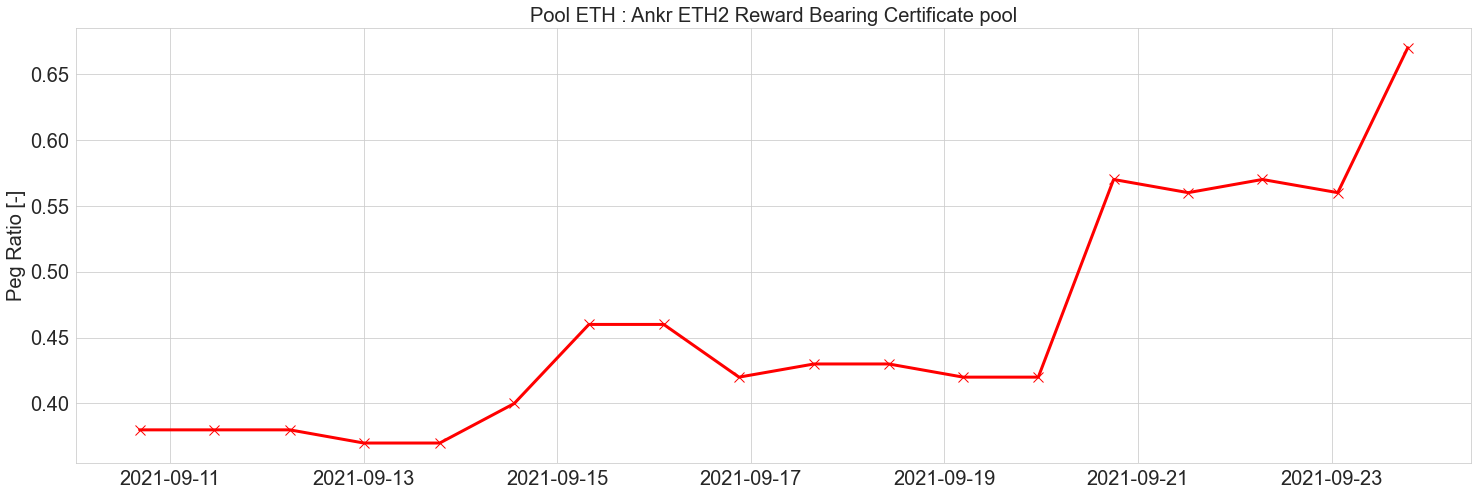

In [38]:
fig, ax = plt.subplots(1,1, figsize=(25, 8))


ax.plot(df_plot.timestamp, df_plot.peg_ratio, 'rx-', lw=3, ms=10)

# ax.axvline(x=A, label="Current A", color='k', ls='--')

ax.set_ylabel("")
ax.set_ylabel("Peg Ratio [-]", fontsize=20)
ax.set_title(f"Pool {coin_0} : {coin_1} pool", fontsize=20);
ax.tick_params(axis='both', which='major', labelsize=20);

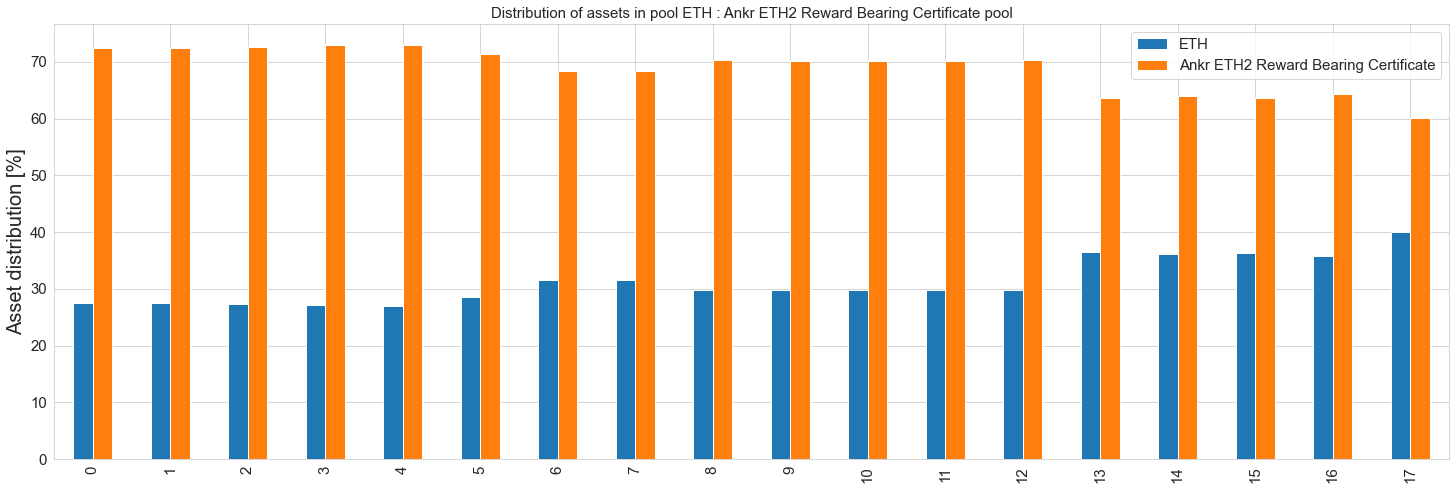

In [30]:
fig, ax = plt.subplots(1,1, figsize=(25, 8))

df_plot[["coin_0_perc", "coin_1_perc"]].plot(ax=ax, kind="bar")

# ax.axvline(x=A, label="Current A", color='k', ls='--')

ax.set_ylabel("Asset distribution [%]", fontsize=20)
ax.set_title(f"Distribution of assets in pool {coin_0} : {coin_1} pool", fontsize=15);
ax.tick_params(axis='both', which='major', labelsize=15);

ax.legend([coin_0, coin_1], fontsize=15);

disconnect

In [ ]:
brownie.network.disconnect()